In [32]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from src.utils.load_dataframe import load_time_series_60min

1. Selección de la columna objetivo y preprocesamiento de datos

In [34]:

df = load_time_series_60min()
# Seleccionar la columna de demanda de energía para Alemania
target_column = 'DE_load_actual_entsoe_transparency'
y = df[target_column].values

# Predecimos usando sólo la columna objetivo
X = y

# Asegurarnos de que no haya valores nulos
X = X[~np.isnan(X)]
y = y[~np.isnan(y)]


2. Preparación de los datos para LSTM

Las LSTM necesitan datos en formato de secuencia. Por lo tanto, convertimos la serie temporal en una estructura de ventanas de tiempo.

In [35]:


scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X.reshape(-1, 1))  # Escalar X 

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))  # Escalar y

# Función para crear ventanas de tiempo
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Definimos el tamaño de la secuencia
seq_length = 60  # usamos 60 timestamps anteriores para predecir el siguiente

# Crear secuencias a partir de X y y escalados
X_seq, y_seq = create_sequences(X_scaled, seq_length)
y_seq = y_seq.reshape(-1, 1)  

# Redimensionar X para que sea compatible con la entrada LSTM
X_seq = np.reshape(X_seq, (X_seq.shape[0], X_seq.shape[1], 1))


3. División en conjuntos de entrenamiento y prueba

In [36]:

# División en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)


4. Construcción del modelo LSTM

In [37]:
# Construcción del modelo
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compilación del modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenamiento del modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20


/Users/alejandrovelazco/work/master-tfm/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1259/1259 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 0.0235 - val_loss: 0.0019
Epoch 2/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 0.0038 - val_loss: 8.5298e-04
Epoch 3/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 0.0021 - val_loss: 5.9943e-04
Epoch 4/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 0.0016 - val_loss: 5.6983e-04
Epoch 5/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 0.0013 - val_loss: 5.5228e-04
Epoch 6/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 0.0011 - val_loss: 5.8451e-04
Epoch 7/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 0.0010 - val_loss: 4.7722e-04
Epoch 8/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 9.8445e-04 - val_loss: 5.2560e-04
Epoch 9/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 8.9528e-04 - val_loss: 3.6961e-04
Epoch 10/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 8.6186e-04 - val_loss: 3.7175e-04
Epoch 11/20
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - los

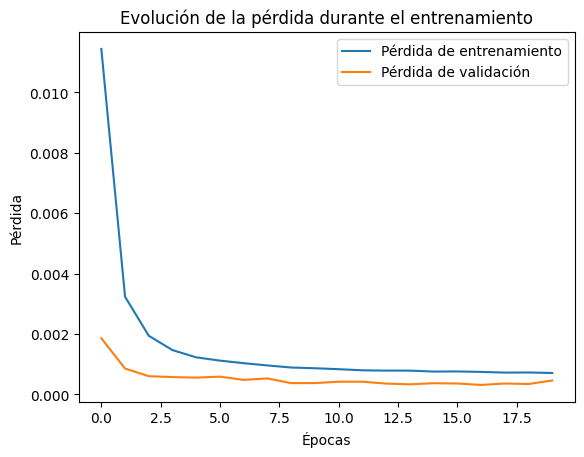

In [38]:
# Gráfico de la pérdida y la pérdida de validación a lo largo de las épocas
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

5. Evaluación del modelo

315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


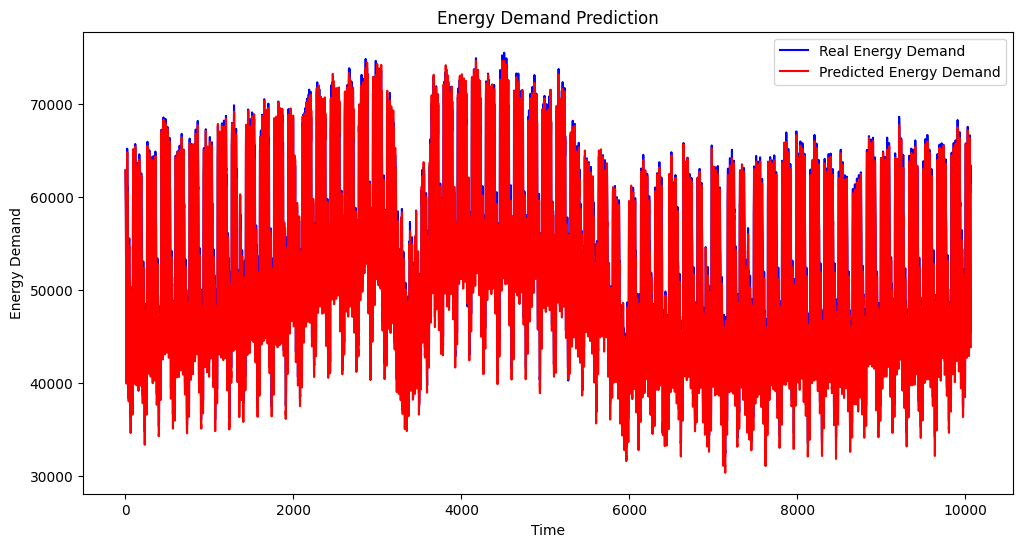

In [39]:
# Hacer predicciones con el modelo
y_pred = model.predict(X_test)

# Inversión del escalado de las predicciones y de los valores reales
y_pred = scaler_y.inverse_transform(y_pred)
y_test = scaler_y.inverse_transform(y_test)


# Graficar resultados
plt.figure(figsize=(12, 6))
plt.plot(y_test, color='blue', label='Real Energy Demand')
plt.plot(y_pred, color='red', label='Predicted Energy Demand')
plt.title('Energy Demand Prediction')
plt.xlabel('Time')
plt.ylabel('Energy Demand')
plt.legend() 
plt.show()


In [40]:

# Evaluar el rendimiento
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')


Mean Squared Error: 978383.4739842421
Mean Absolute Error: 780.9946248323897


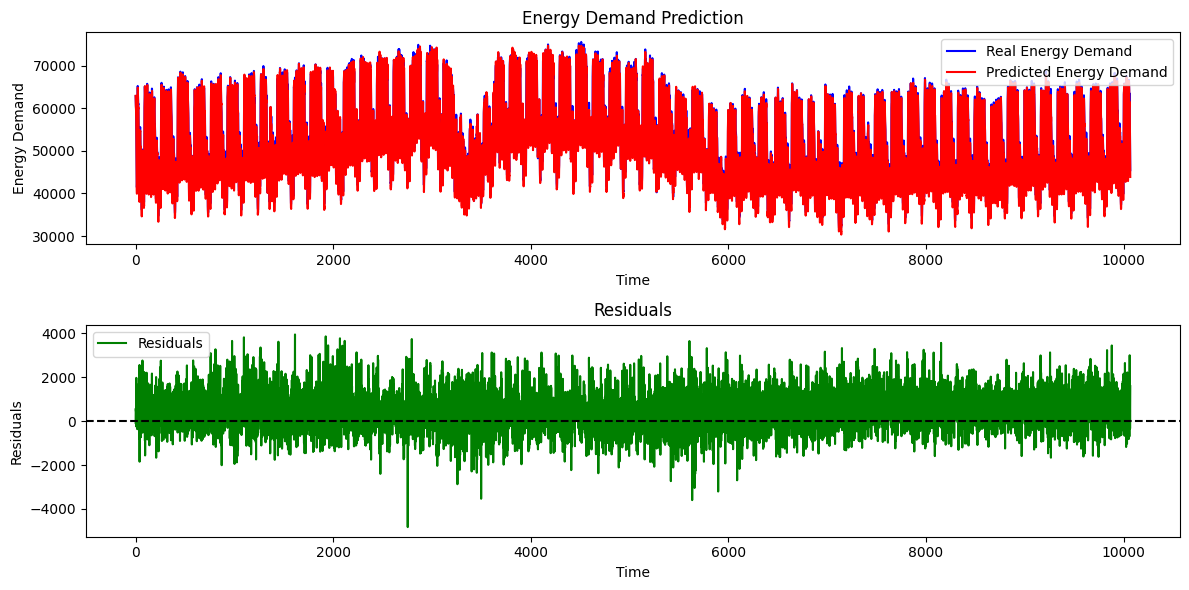

In [41]:
# Calcular los residuos
residuos = y_test - y_pred

# Graficar resultados
plt.figure(figsize=(12, 6))

# Graficar valores reales y predicciones
plt.subplot(2, 1, 1)
plt.plot(y_test, color='blue', label='Real Energy Demand')
plt.plot(y_pred, color='red', label='Predicted Energy Demand')
plt.title('Energy Demand Prediction')
plt.xlabel('Time')
plt.ylabel('Energy Demand')
plt.legend()

# Graficar residuos
plt.subplot(2, 1, 2)
plt.plot(residuos, color='green', label='Residuals')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Residuals')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()

plt.tight_layout()
plt.show()

Vamos a usar el modelo anterior para hacer predicciones para el año 2020 y luego convertirlas en predicciones mensuales

In [42]:
# Asegurarse de que el índice sea una columna de tipo datetime
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])

# Filtrar los datos para el año 2020
df_2020 = df[df['utc_timestamp'].dt.year == 2020]


In [43]:
# Seleccionar la columna de demanda de energía para Alemania
target_column = 'DE_load_actual_entsoe_transparency'
y_2020 = df_2020[target_column].values

# Escalar los datos
y_2020_scaled = scaler_y.transform(y_2020.reshape(-1, 1))  # Usar el mismo scaler que en el entrenamiento

# Crear secuencias a partir de los datos de 2020
X_2020_seq, _ = create_sequences(y_2020_scaled, seq_length)

# Redimensionar X para que sea compatible con la entrada LSTM
X_2020_seq = np.reshape(X_2020_seq, (X_2020_seq.shape[0], X_2020_seq.shape[1], 1))


In [44]:
# Realizar predicciones sobre los datos del año 2020
predicciones_2020_scaled = model.predict(X_2020_seq)

# Invertir la normalización de las predicciones para volver a la escala original
predicciones_2020 = scaler_y.inverse_transform(predicciones_2020_scaled)


204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [45]:
# Crear un DataFrame con las predicciones y las fechas correspondientes
predicciones_2020_df = pd.DataFrame({
    'utc_timestamp': df_2020['utc_timestamp'][seq_length:],  # Ajustar por el seq_length
    'predicciones': predicciones_2020.flatten()  # Aplanar para tener una serie 1D
})

# Agrupar por mes y sumar las predicciones
predicciones_mensuales_2020 = predicciones_2020_df.resample('M', on='utc_timestamp').sum()

# O puedes usar .mean() si prefieres el promedio en lugar de la suma
# predicciones_mensuales_2020 = predicciones_2020_df.resample('M', on='utc_timestamp').mean()


/var/folders/54/ddzf5nq5133324qrz2cb0_gc0000gn/T/ipykernel_28028/3392308355.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  predicciones_mensuales_2020 = predicciones_2020_df.resample('M', on='utc_timestamp').sum()


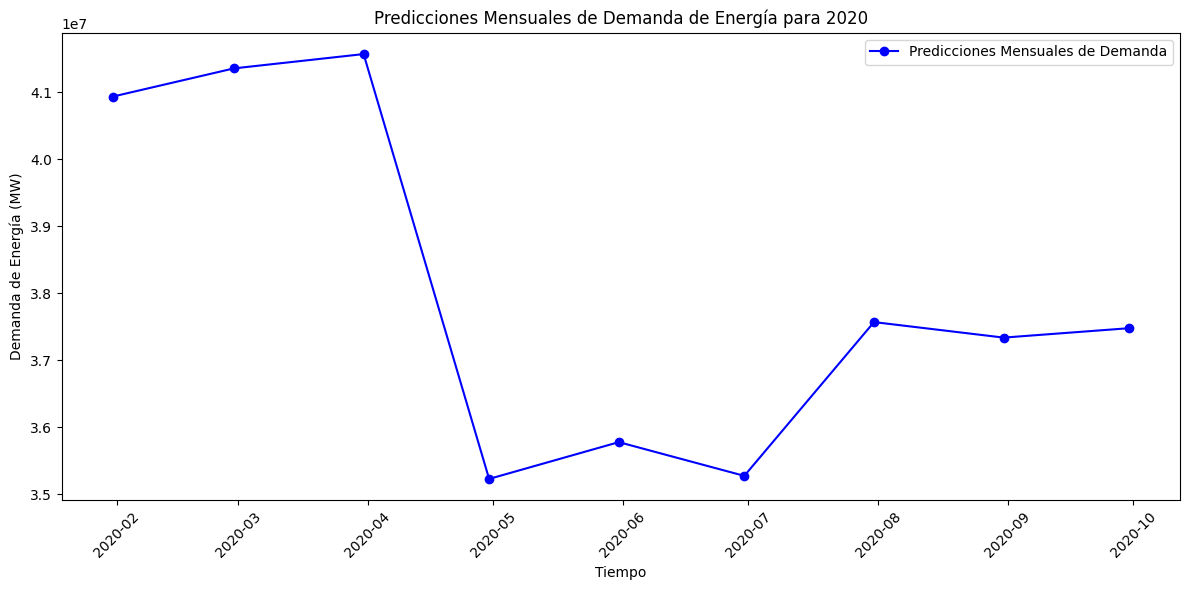

In [46]:

# Graficar las predicciones mensuales
plt.figure(figsize=(12, 6))
plt.plot(predicciones_mensuales_2020.index, predicciones_mensuales_2020['predicciones'], color='blue', marker='o', label='Predicciones Mensuales de Demanda')
plt.title('Predicciones Mensuales de Demanda de Energía para 2020')
plt.xlabel('Tiempo')
plt.ylabel('Demanda de Energía (MW)')
plt.legend()

# Ajustar el formato del eje x para mostrar fechas
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Etiquetas cada mes

plt.xticks(rotation=45)  # Rotar etiquetas para mejor visibilidad
plt.tight_layout()  # Ajustar el layout para que no se solapen los textos

# Mostrar la gráfica
plt.show()


Comparar la predicción con los valores reales:

In [47]:
# Filtrar la demanda real para el año 2020
real_demand_2020 = df_2020['DE_load_actual_entsoe_transparency'].values


/var/folders/54/ddzf5nq5133324qrz2cb0_gc0000gn/T/ipykernel_28028/1095314885.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  real_demand_mensual_2020 = real_demand_2020_df.resample('M', on='utc_timestamp').sum()


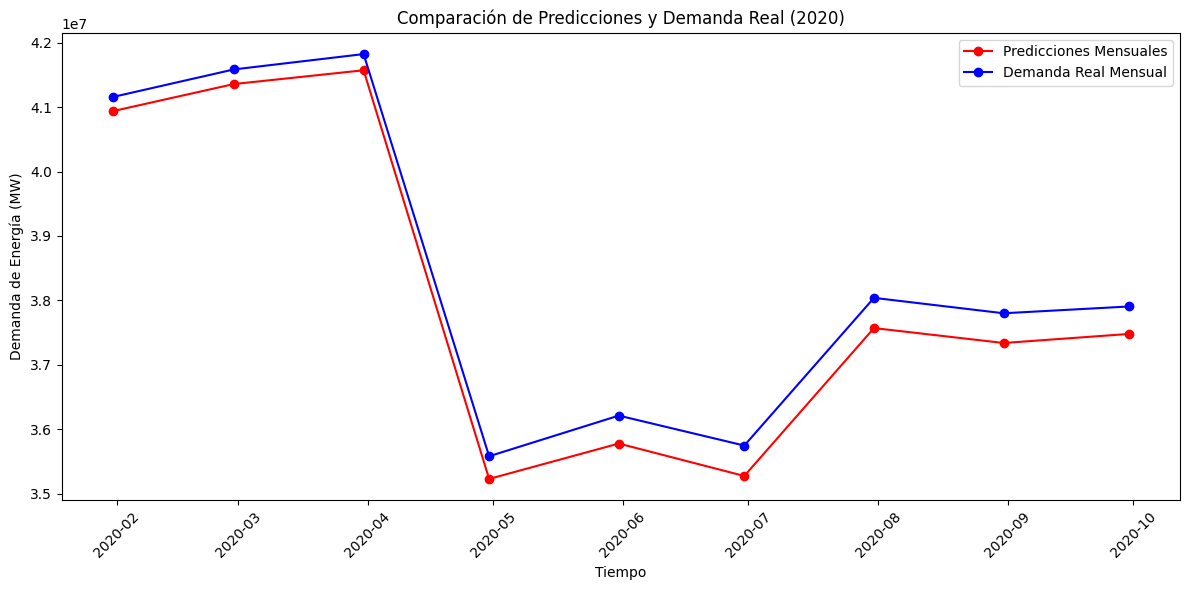

In [48]:
# Filtrar la demanda real para el año 2020
real_demand_2020 = df_2020['DE_load_actual_entsoe_transparency'].values[seq_length:]

# Crear un DataFrame para las predicciones mensuales reales
real_demand_2020_df = pd.DataFrame({
    'utc_timestamp': df_2020['utc_timestamp'].values[seq_length:],  # Ajustar por el seq_length
    'demanda_real': real_demand_2020
})

# Agrupar la demanda real por mes
real_demand_mensual_2020 = real_demand_2020_df.resample('M', on='utc_timestamp').sum()

# Graficar las predicciones y la demanda real mensuales
plt.figure(figsize=(12, 6))
plt.plot(predicciones_mensuales_2020.index, predicciones_mensuales_2020['predicciones'], color='red', marker='o', label='Predicciones Mensuales')
plt.plot(real_demand_mensual_2020.index, real_demand_mensual_2020['demanda_real'], color='blue', marker='o', label='Demanda Real Mensual')
plt.title('Comparación de Predicciones y Demanda Real (2020)')
plt.xlabel('Tiempo')
plt.ylabel('Demanda de Energía (MW)')
plt.legend()

# Ajustar el formato del eje x para mostrar fechas
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Etiquetas cada mes

plt.xticks(rotation=45)  # Rotar etiquetas para mejor visibilidad
plt.tight_layout()  # Ajustar el layout para que no se solapen los textos

# Mostrar la gráfica
plt.show()
